# Шаг 1

Импорт библиотек, датасета, форматирование данных под нужный формат для анализа

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from pandas.core.nanops import nanmean as pd_nanmean
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')
energy_consumption = pd.read_csv('C:/Users/Елизавета/Desktop/Учёба/Проект/AEP_hourly_1.csv')
energy_consumption

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [2]:
energy_consumption.iloc[:-30000]
energy_consumption.sort_values('Datetime', axis = 0, inplace = True) #сортируем по времени
energy_consumption = energy_consumption.iloc[-30000:] #сокращаем размер датасета до 30к данных
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption.Datetime, format='%Y-%m-%d %H:%M:%S')
energy_consumption.index = energy_consumption.Datetime #превращаем индексы во времы
energy_consumption.drop('Datetime', axis = 1, inplace = True) #удаляем datetime
energy_consumption = energy_consumption.dropna()
energy_consumption

,AEP_MW
Datetime,
2015-03-02 00:00:00,15867.0
2015-03-02 01:00:00,15444.0
2015-03-02 02:00:00,15307.0
2015-03-02 03:00:00,15328.0
2015-03-02 04:00:00,15373.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


# Шаг 2

Проведение теста на стационарность ряда

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

from statsmodels.tsa.stattools import adfuller

print('Результат теста:')
df_result = adfuller(energy_consumption['AEP_MW'])
df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
for result_value, label in zip(df_result, df_labels):
    print(label + ' : ' + str(result_value))

if df_result[1] <= 0.05:
    print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
else:
    print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")


Результат теста:
ADF Test Statistic : -11.750672615780092
p-value : 1.2113270198979786e-21
#Lags Used : 50
Number of Observations Used : 29949
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


# Шаг 3

Построим графики ACF и PACF для определения параметров p и q

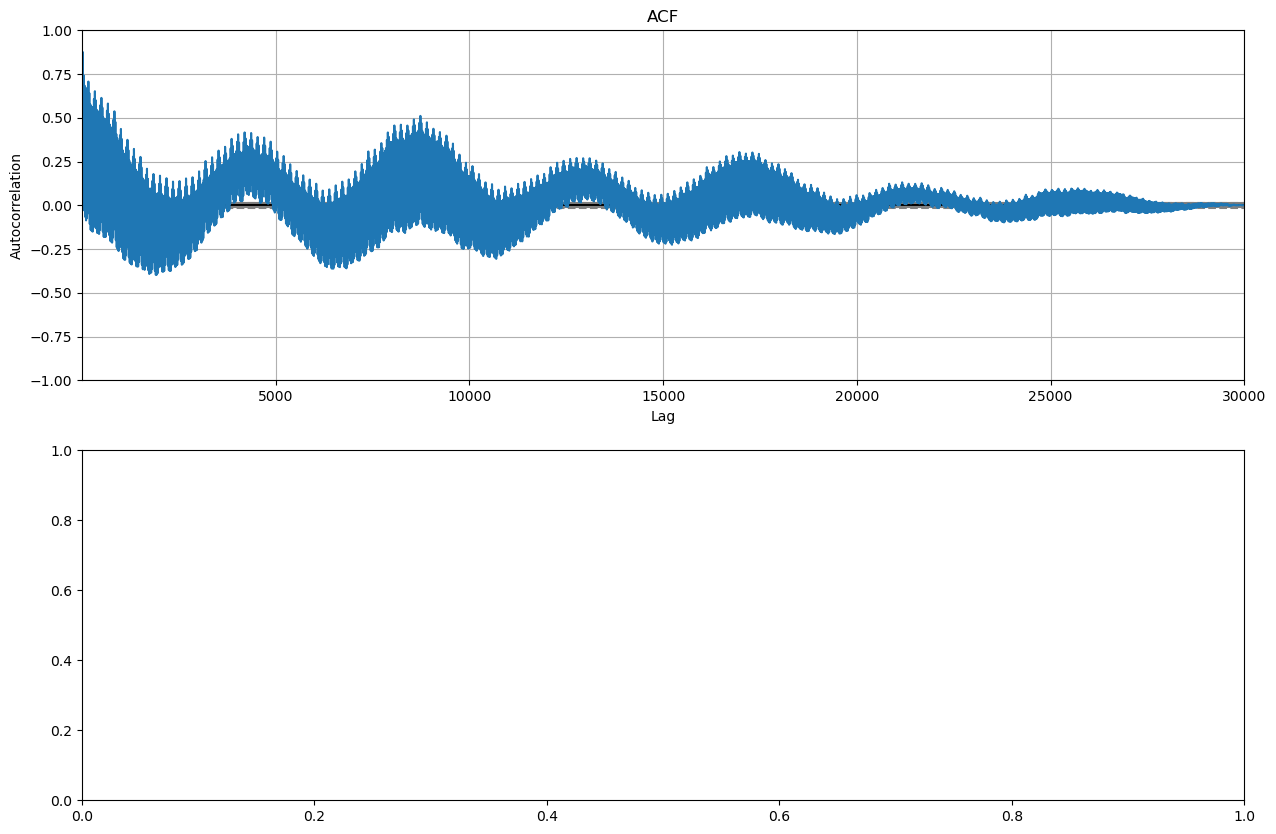

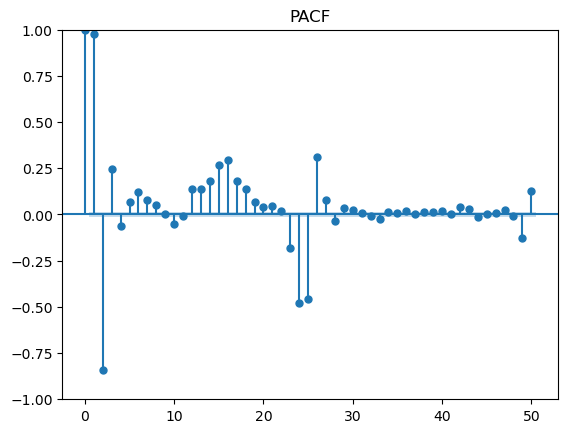

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15, 10))

plt.subplot(211)
autocorrelation_plot(energy_consumption['AEP_MW'])
plt.title('ACF')

plt.subplot(212)
plot_pacf(energy_consumption['AEP_MW'], lags=50)
plt.title('PACF')

best_aic = np.inf
best_p = None
best_q = None
best_model = None
plt.show()

# Шаг 4

Перебор возможных значений p и q

In [5]:
best_aic = np.inf
best_p = None
best_q = None
best_model = None
for p in range(2):
    for q in range(2):  
        try:
            model = ARIMA(energy_consumption['AEP_MW'], order=(p, 0, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_p = p
                best_q = q
                best_model = results
        except:
            continue

print(f'Best ARIMA model order: p={best_p}, q={best_q} with AIC={best_aic}')


Best ARIMA model order: p=1, q=1 with AIC=437937.3238135732


# Шаг 5
Построение модели ARIMA

In [6]:
p =  best_p
q =  best_q

# d=0, так как ряд стационарный
model = ARIMA(energy_consumption['AEP_MW'], order=(p, 0, q))
model_fit = model.fit()

# Выводим результат
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                30000
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -218964.662
Date:                Sat, 30 Mar 2024   AIC                         437937.324
Time:                        20:39:00   BIC                         437970.560
Sample:                             0   HQIC                        437947.988
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.466e+04    110.565    132.612      0.000    1.44e+04    1.49e+04
ar.L1          0.9671      0.002    605.204      0.000       0.964       0.970
ma.L1          0.7473      0.002    342.273      0.0

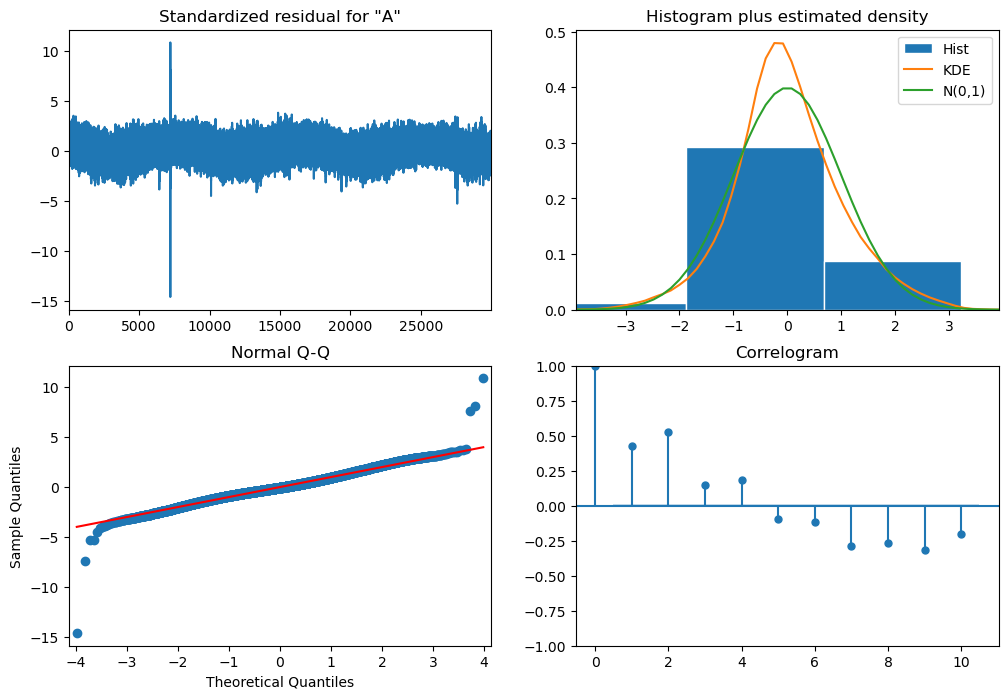

In [7]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

### Вывод: по графикам можем заметить, что p и q подобраны корректно

# Шаг 6
Статический прогноз для сравнения предсказанных и реальных данных

Среднеквадратичная ошибка прогноза составляет 140637.52 Figure(1500x800)


<Figure size 1500x800 with 0 Axes>

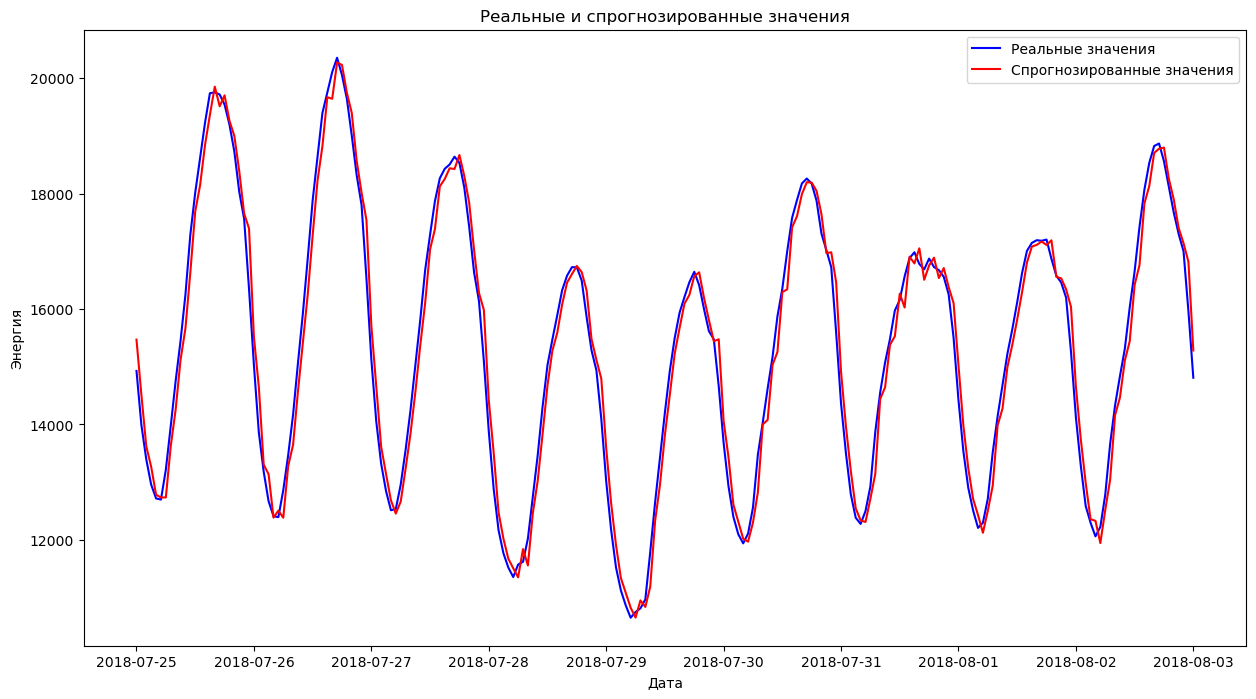

In [8]:
st_pred = model_fit.get_prediction(start=pd.to_datetime('2018-07-25'), dynamic=False) 
forecast_values = st_pred.predicted_mean

actual_values = energy_consumption['2018-07-25':]['AEP_MW']
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(forecast_mse, 2)), plt.figure(figsize=(15,8)))

plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')

plt.title('Реальные и cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Энергия')
plt.legend()

plt.show()

### Вывод - модель хорошо предсказывает данные

# Шаг 7
Создание и визуализация прогноза

In [9]:
pred_future = model_fit.get_forecast(steps=7000)
print(f'Средние прогнозируемые значения:\n\n{pred_future.predicted_mean}')
print(f'\nДоверительные интервалы:\n\n{pred_future.conf_int()}')

Средние прогнозируемые значения:

30000    14450.991850
30001    14457.937350
30002    14464.654378
30003    14471.150448
30004    14477.432829
             ...     
36995    14662.132874
36996    14662.132874
36997    14662.132874
36998    14662.132874
36999    14662.132874
Name: predicted_mean, Length: 7000, dtype: float64

Доверительные интервалы:

       lower AEP_MW  upper AEP_MW
30000  13749.834733  15152.148967
30001  13066.331796  15849.542904
30002  12651.366989  16277.941767
30003  12337.607177  16604.693719
30004  12082.811376  16872.054283
...             ...           ...
36995   9884.912835  19439.352913
36996   9884.912835  19439.352913
36997   9884.912835  19439.352913
36998   9884.912835  19439.352913
36999   9884.912835  19439.352913

[7000 rows x 2 columns]


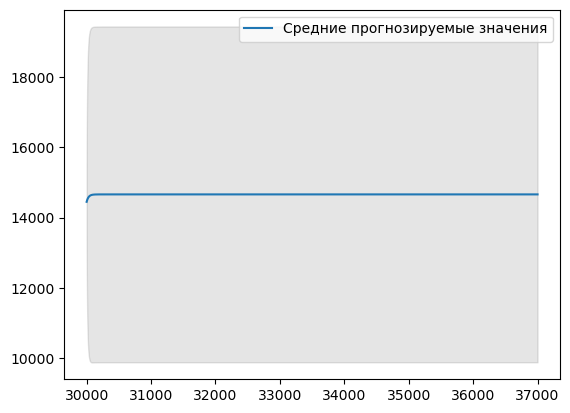

In [10]:
fig = plt.figure()
plt.plot(pred_future.predicted_mean, label='Средние прогнозируемые значения')
plt.fill_between(pred_future.conf_int().index,
                 pred_future.conf_int().iloc[:, 0],
                 pred_future.conf_int().iloc[:, 1], color='k', alpha=.1)
plt.legend()  
plt.show()

### Прогноз построен. Осталось соединить два датафрейма 
# Шаг 8


In [11]:
forecast_df = pd.DataFrame(pred_future.predicted_mean)
forecast_df.columns=['AEP_MW']
last_timestamp = energy_consumption.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=(len(forecast_df) + 1), freq='H')[1:]
future_timestamps #на эти времена мы сделали прогноз


DatetimeIndex(['2018-08-03 01:00:00', '2018-08-03 02:00:00',
               '2018-08-03 03:00:00', '2018-08-03 04:00:00',
               '2018-08-03 05:00:00', '2018-08-03 06:00:00',
               '2018-08-03 07:00:00', '2018-08-03 08:00:00',
               '2018-08-03 09:00:00', '2018-08-03 10:00:00',
               ...
               '2019-05-21 07:00:00', '2019-05-21 08:00:00',
               '2019-05-21 09:00:00', '2019-05-21 10:00:00',
               '2019-05-21 11:00:00', '2019-05-21 12:00:00',
               '2019-05-21 13:00:00', '2019-05-21 14:00:00',
               '2019-05-21 15:00:00', '2019-05-21 16:00:00'],
              dtype='datetime64[ns]', length=7000, freq='H')

In [12]:
forecast_df.index = future_timestamps #сделали из меток индексы предсказанного датафрейма
complete_dataset = pd.concat([energy_consumption, forecast_df])
complete_dataset

,AEP_MW
2015-03-02 00:00:00,15867.000000
2015-03-02 01:00:00,15444.000000
2015-03-02 02:00:00,15307.000000
2015-03-02 03:00:00,15328.000000
2015-03-02 04:00:00,15373.000000
...,...
2019-05-21 12:00:00,14662.132874
2019-05-21 13:00:00,14662.132874
2019-05-21 14:00:00,14662.132874
2019-05-21 15:00:00,14662.132874
